# 🎬 Movie Rating Prediction using XGBoost

This notebook predicts movie ratings using metadata from the TMDB 5000 dataset. We'll follow a structured ML pipeline similar to the Breast Cancer Classification notebook.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")


In [15]:
# Load datasets
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

# Merge on movie ID
movies = movies.merge(credits, left_on='id', right_on='movie_id', how='left')
movies.shape


(4803, 24)

## 🧹 Data Preprocessing

In [16]:
# Use the correct column names
movies = movies[['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'title_x', 'genres', 'cast', 'crew']]
movies.rename(columns={'title_x': 'title'}, inplace=True)


## 🛠️ Feature Engineering

In [17]:
import ast

# Convert JSON-like columns to proper Python objects
def parse_names(obj):
    try:
        return [item['name'] for item in ast.literal_eval(obj)]
    except:
        return []

movies['genres'] = movies['genres'].apply(parse_names)
movies['cast'] = movies['cast'].apply(parse_names)
movies['crew'] = movies['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x) if i['job'] == 'Director'] if pd.notna(x) else [])

# Use only first genre, actor, and director for simplicity
movies['main_genre'] = movies['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
movies['main_actor'] = movies['cast'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
movies['director'] = movies['crew'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# Encode categorical features
le_genre = LabelEncoder()
le_actor = LabelEncoder()
le_director = LabelEncoder()

movies['genre_encoded'] = le_genre.fit_transform(movies['main_genre'])
movies['actor_encoded'] = le_actor.fit_transform(movies['main_actor'])
movies['director_encoded'] = le_director.fit_transform(movies['director'])


## 📊 Exploratory Data Analysis

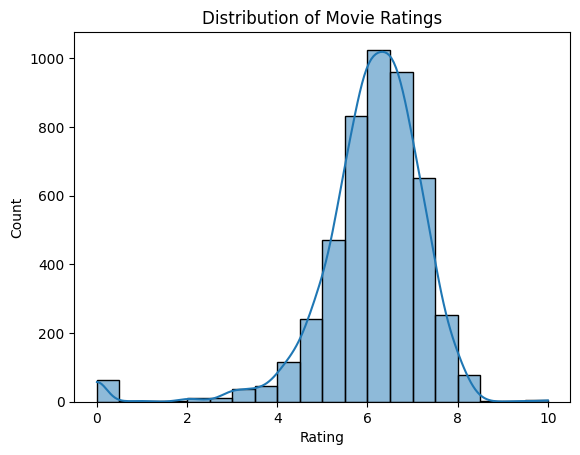

In [18]:
# Rating distribution
sns.histplot(movies['vote_average'], kde=True, bins=20)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


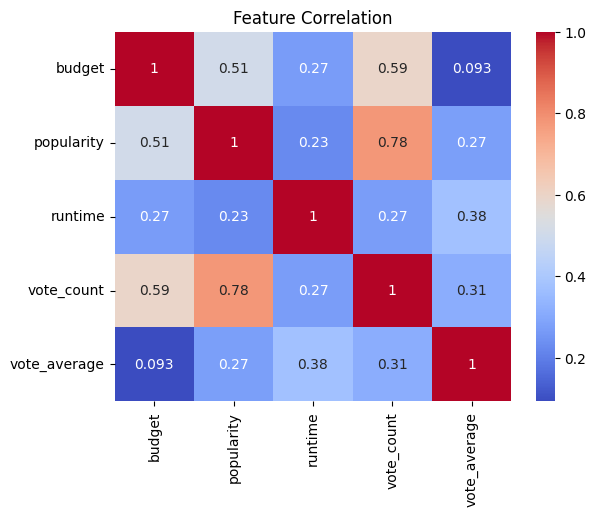

In [19]:
# Correlation Heatmap
sns.heatmap(movies[['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


## 🤖 Model Training with XGBoost

In [20]:
# Features and Target
features = ['budget', 'popularity', 'runtime', 'vote_count', 'genre_encoded', 'actor_encoded', 'director_encoded']
X = movies[features]
y = movies['vote_average']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


## 📈 Model Evaluation

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Root Mean Squared Error: 0.72
R² Score: 0.65


## 🧠 Model Comparison

Let's compare **XGBoost Regressor** with another common model: **Random Forest Regressor**.
We'll evaluate both using Root Mean Squared Error (RMSE) and R² Score.

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Metrics for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

# Print comparison
print("📊 Model Performance Comparison:")
print(f"XGBoost  → RMSE: {rmse:.2f}, R²: {r2:.2f}")
print(f"Random Forest → RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")


📊 Model Performance Comparison:
XGBoost  → RMSE: 0.72, R²: 0.65
Random Forest → RMSE: 0.74, R²: 0.63


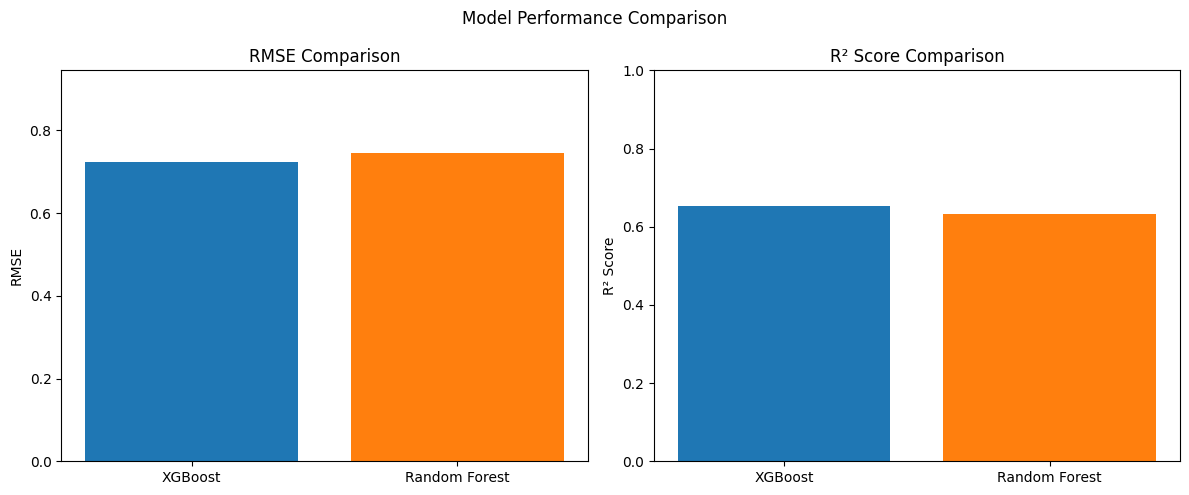

In [23]:
# Bar chart for comparison
labels = ['XGBoost', 'Random Forest']
rmse_scores = [rmse, rf_rmse]
r2_scores = [r2, rf_r2]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE plot
ax[0].bar(labels, rmse_scores, color=['#1f77b4', '#ff7f0e'])
ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE")
ax[0].set_ylim(0, max(rmse_scores) + 0.2)

# R² plot
ax[1].bar(labels, r2_scores, color=['#1f77b4', '#ff7f0e'])
ax[1].set_title("R² Score Comparison")
ax[1].set_ylabel("R² Score")
ax[1].set_ylim(0, 1)

plt.suptitle("Model Performance Comparison")
plt.tight_layout()
plt.show()


🏁 Final Model Comparison Summary
Based on the evaluation of both models, here are the final results:

🔢 RMSE (Root Mean Squared Error)
XGBoost: 0.72 ✅ (Lower is better)

Random Forest: 0.74

📈 R² Score (Coefficient of Determination)
XGBoost: 0.65 ✅ (Higher is better)

Random Forest: 0.63

🏆 Conclusion
XGBoost outperforms Random Forest by a small margin in both RMSE and R², making it the better model for predicting movie ratings in this notebook.